<a href="https://colab.research.google.com/github/SampMark/Computational-Thinking/blob/main/Modeling_Climate_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelando Mudanças Climáticas**

No conjunto de dados analisado a seguir, 'tempetures.csv', estão registradas as temperaturas altas e baixas diárias para 21 cidades dos EUA, exceto Alasca e Havaí. A partir dos dados históricos de muitos anos, entre 1961 a 2016, há 421.848 observações, será modelado o comportamento do clima em diferentes cidades e períodos por meio de análises de regressão, para tentar encontrar evidências do aquecimento global.

## **Importando e instalando as bibliotecas**

In [172]:
# Instalando as bibliotecas necessárias
!pip install pandas numpy matplotlib

In [173]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from io import StringIO
import requests

# Configurar gráficos no ambiente Colab
%matplotlib inline

## **Classe `Climate`**

A classe Climate é projetada para gerenciar registros de temperatura extraídos do arquivo 'temperatures.csv', permitindo acessar dados organizados por cidade, ano, mês e dia. É a base para obter dados do problema, permitindo a geração de y como as médias anuais de temperatura e possibilitando a análise de tendências usando modelos de regressão.

**Atributo:**
* `rawdata (dict)`: Um dicionário que organiza os dados de temperatura.

**Métodos:**
* `__init__(self, url)`: construtor que inicializa a classe, carregando os dados de um arquivo CSV disponível em uma URL, usando `requests.get` processa cada linha do DataFrame do Pandas e organiza os dados no dicionário `rawdata`: extrai a data (DATE) e separa em year, month, day, recupera a cidade (CITY) e a temperatura (TEMP). Este método prepara os dados para consulta por outros métodos da classe.

* `get_yearly_temp(self, city, year)`: obtém as temperaturas diárias de um ano específico para uma cidade fornecida, organiza o `numpy.ndarray`,contendo as temperaturas diárias do ano especificado. Lança erros caso a cidade ou o ano não estejam disponíveis nos dados.

* `get_daily_temp(self, city, month, day, year)`: obtém a temperatura registrada em um dia específico para uma cidade e ano fornecidos. Lança erros caso a cidade, ano, mês ou dia não estejam disponíveis nos dados.

In [174]:
# Lista de cidades no dataset
CITIES = [
    'BOSTON',
    'SEATTLE',
    'SAN DIEGO',
    'PHILADELPHIA',
    'PHOENIX',
    'LAS VEGAS',
    'CHARLOTTE',
    'DALLAS',
    'BALTIMORE',
    'SAN JUAN',
    'LOS ANGELES',
    'MIAMI',
    'NEW ORLEANS',
    'ALBUQUERQUE',
    'PORTLAND',
    'SAN FRANCISCO',
    'TAMPA',
    'NEW YORK',
    'DETROIT',
    'ST LOUIS',
    'CHICAGO'
]

INTERVAL_1 = list(range(1961, 2006))
INTERVAL_2 = list(range(2006, 2016))

class Climate:
    """
    Classe para organizar registros de temperatura carregados de um arquivo CSV.

    Atributos:
        rawdata (dict): Dicionário contendo os dados organizados por cidade, ano, mês e dia.

    Métodos:
        __init__(self, filename): Inicializa a classe e carrega os dados do arquivo CSV.
    """
    def __init__(self, url):
        """
        Inicializa a classe Climate com dados de uma URL fornecida.

        Args:
            url (str): URL para o arquivo CSV contendo os registros de temperatura.
        """
        self.rawdata = {}
        # Lê os dados diretamente da URL usando pandas
        response = requests.get(url)
        data = pd.read_csv(StringIO(response.text))

        for _, row in data.iterrows():
            date = re.match(r'(\d\d\d\d)(\d\d)(\d\d)', str(row['DATE']))
            year = int(date.group(1))
            month = int(date.group(2))
            day = int(date.group(3))
            city = row['CITY']
            temperature = float(row['TEMP'])
            if city not in self.rawdata:
                self.rawdata[city] = {}
            if year not in self.rawdata[city]:
                self.rawdata[city][year] = {}
            if month not in self.rawdata[city][year]:
                self.rawdata[city][year][month] = {}
            self.rawdata[city][year][month][day] = temperature

    def get_yearly_temp(self, city, year):
        """
        Obtém as temperaturas diárias de um ano específico para uma cidade fornecida.

        Args:
            city (str): Nome da cidade.
            year (int): Ano para o qual os dados de temperatura serão obtidos.

        Returns:
            numpy.ndarray: Um array 1D contendo as temperaturas diárias para a cidade e o ano especificados.
        """
        temperatures = []
        assert city in self.rawdata, "A cidade fornecida não está disponível."
        assert year in self.rawdata[city], "O ano fornecido não está disponível."
        for month in range(1, 13):
            for day in range(1, 32):
                if day in self.rawdata[city][year][month]:
                    temperatures.append(self.rawdata[city][year][month][day])
        return np.array(temperatures)

    def get_daily_temp(self, city, month, day, year):
        """
        Obtém a temperatura de um dia específico para uma cidade e ano fornecidos.

        Args:
            city (str): Nome da cidade.
            month (int): Mês do ano (1 para Janeiro, 12 para Dezembro).
            day (int): Dia do mês.
            year (int): Ano.

        Returns:
            float: A temperatura diária para o dia, mês, ano e cidade especificados.
        """
        assert city in self.rawdata, "A cidade fornecida não está disponível."
        assert year in self.rawdata[city], "O ano fornecido não está disponível."
        assert month in self.rawdata[city][year], "O mês fornecido não está disponível."
        assert day in self.rawdata[city][year][month], "O dia fornecido não está disponível."
        return self.rawdata[city][year][month][day]

## **Função `generate_models`**

A função generate_models ajusta modelos de regressão polinomial a um conjunto de dados (𝑥,𝑦) e calcula os coeficientes dos polinômios de graus especificados e retorna esses modelos para análise posterior. Retorna uma lista de `numpy.ndarray`, onde cada array contém os coeficientes do polinômio ajustado para o grau correspondente, usando `numpy.polyfit`.

In [175]:
def generate_models(x, y, degs):
    """
    Gera modelos de regressão ajustando um polinômio para cada grau fornecido.

    Args:
        x (list or np.ndarray): Lista ou array de coordenadas x (comprimento N).
        y (list or np.ndarray): Lista ou array de coordenadas y (comprimento N).
        degs (list): Lista de graus inteiros dos polinômios a serem ajustados.

    Returns:
        list: Lista de arrays NumPy, onde cada array contém os coeficientes
              do polinômio ajustado para o respectivo grau.
    """
    # Validações
    if len(x) != len(y):
        raise ValueError("As listas x e y devem ter o mesmo comprimento.")
    if not all(isinstance(d, int) and d >= 0 for d in degs):
        raise TypeError("A lista degs deve conter apenas inteiros não negativos.")

    # Garantir que x e y sejam arrays NumPy
    x = np.array(x)
    y = np.array(y)

    models = []
    for d in degs:
        coeffs = np.polyfit(x, y, d) # Ajuste do polinômio
        models.append(coeffs) # Adiciona os coeficientes à lista
    return models

# Resultados do teste
print(generate_models([1961, 1962, 1963],[4.4,5.5,6.6],[1, 2]))
print(generate_models([1900, 1901, 1902, 1904, 2000], [32.0, 42.0, 31.3, 22.0, 33.0], [2]))
print(generate_models([1960, 1997, 1999, 2001], [-3.1, -4.1, -9.2, 10.1], [1, 2, 3]))
print(generate_models([1960, 1997, 1999, 2001, 1998, 1995], [-3.1, -4.1, -9.2, 10.1, 9.1, 4.5], [1, 2, 3, 4]))

[array([ 1.1000e+00, -2.1527e+03]), array([-8.86320608e-14,  1.10000000e+00, -2.15270000e+03])]
[array([ 3.51667102e-02, -1.37199002e+02,  1.33764160e+05])]
[array([ 7.64961915e-02, -1.53745049e+02]), array([ 9.24663056e-02, -3.66029000e+02,  3.62195201e+05]), array([ 7.59680860e-02, -4.52530612e+02,  8.98514989e+05, -5.94652222e+08])]
[array([ 1.43651226e-01, -2.84888692e+02]), array([ 1.45050481e-02, -5.72778422e+01,  5.65389304e+04]), array([ 2.41178585e-02, -1.43636842e+02,  2.85137445e+05, -1.88670385e+08]), array([ 1.14194332e-02, -9.08068819e+01,  2.70778713e+05, -3.58854125e+08,
        1.78337522e+11])]


## **Função `r_squared`**

A função r_squared calcula o coeficiente de determinação (𝑅2), para medir a qualidade do ajuste de um modelo de regressão em relação aos dados observados.

O valor de 𝑅2 varia entre 0 e 1, onde:

* `𝑅2 = 1`: o modelo explica perfeitamente os dados.
* `𝑅2 = 0`: o modelo não explica nada dos dados.

In [176]:
def r_squared(y, estimated):
    """
    Calcula o coeficiente de determinação (R-squared).

    Args:
        y: lista de comprimento N, representando as coordenadas y dos pontos de amostra.
        estimated: lista de valores estimados pelo modelo de regressão.

    Returns:
        float: O valor de R² indicando a qualidade do ajuste.
    """
    if len(y) != len(estimated):
        raise ValueError("As listas 'y' e 'estimate' devem ter o mesmo comprimento.")
    y = np.array(y)
    estimated = np.array(estimated)
    # Calcula a média dos valores y.
    mean_y = np.mean(y)
    # Calcula a soma dos quadrados totais (SST).
    ss_tot = np.sum((y - mean_y) ** 2)
    # Calcula a soma dos quadrados dos resíduos (SSR).
    ss_res = np.sum((y - estimated) ** 2)
    # Calcula o R².
    return 1 - (ss_res / ss_tot)

# Resultados do teste
print(r_squared([32.0, 42.0, 31.3, 22.0, 33.0], [32.3, 42.1, 31.2, 22.1, 34.0]))
print(r_squared([4.4, 5.5, 6.6], [4.4, 5.5, 6.6]))
print(r_squared([-3.1, -4.1, -9.2, 10.1], [-2.1, -6.1, 9.2, 20.1]))
print(r_squared([-3.1, -4.1, -9.2, 10.1, 9.1, 4.5], [-1.1, -2.1, -7.2, 11.1, 11.1, 5.5]))

0.9944409148665819
1.0
-1.1834381422365525
0.9414154674015047


## **Função `evaluate_models_on_training`**

A função `evaluate_models_on_training` recebe os dados (x e y) e uma lista de modelos (listas de coeficientes), gerando um gráfico de pontos para cada modelo, com curva de regressão ajustada.
Inclui um título com informações sobre o modelo e o valor de 𝑅2.
Calcula e exibe o coeficiente de determinação (𝑅2).

Essa função avalia o desempenho de modelos de regressão ajustados, utilizando os dados de treinamento 𝑥 e 𝑦 e plota gráficos comparando os dados observados com os valores previstos pelo modelo e calcula o coeficiente de determinação (𝑅2) para cada modelo.

In [179]:
def evaluate_models_on_training(x, y, models):
    """
    Avalia modelos de regressão e plota gráficos com os dados e as curvas ajustadas.

    Args:
        x: Lista ou array de coordenadas x.
        y: Lista ou array de coordenadas y.
        models: Lista de modelos, onde cada modelo é uma lista de coeficientes.
    """
    x = np.array(x)
    y = np.array(y)
    for model in models:
        if model is not None:
            estimate = np.polyval(model, x)
            r2 = r_squared(y, estimate)
            plt.figure(figsize=(8, 6))
            plt.plot(x, y, 'bo', label='Dados')
            plt.plot(x, estimate, 'r-', label=f'Modelo (grau {len(model) - 1})')
            plt.xlabel('Ano')
            plt.ylabel('Temperatura (°C)')
            plt.title(f'Modelo e Dados\nR² = {r2:.4f}')
            plt.legend(loc='best')
            plt.grid(True)
            plt.show()
            print(f"Qualidade do ajuste (R²): {r2:.4f}")

# URL do arquivo CSV
url = "https://raw.githubusercontent.com/SampMark/files/refs/heads/main/temperatures.csv"

# Carregar dados climáticos
raw_data = Climate(url)

**Exemplo do Problema 3**

* `x`: Intervalo 1 de anos: 1961 a 2005.
* `y`: Temperaturas de 10 de janeiro em Boston nos respectivos anos.
* `models`: modelo ajustado ao polinômio de grau 1.

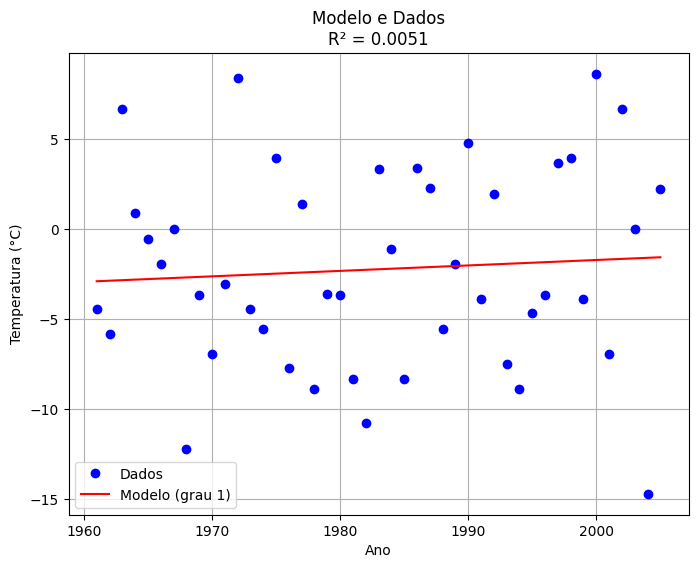

Qualidade do ajuste (R²): 0.0051


In [178]:
# Problema 3
y = []
x = INTERVAL_1
for year in INTERVAL_1:
    y.append(raw_data.get_daily_temp('BOSTON', 1, 10, year))
models = generate_models(x, y, [1])
evaluate_models_on_training(x, y, models)

**Exemplo do Problema 4**

* `x`: Intervalo 1, anos 1961 a 2005.
* `y`: Temperaturas em Boston nos respectivos anos.
* `models`: modelo ajustado ao polinômio de grau 1.

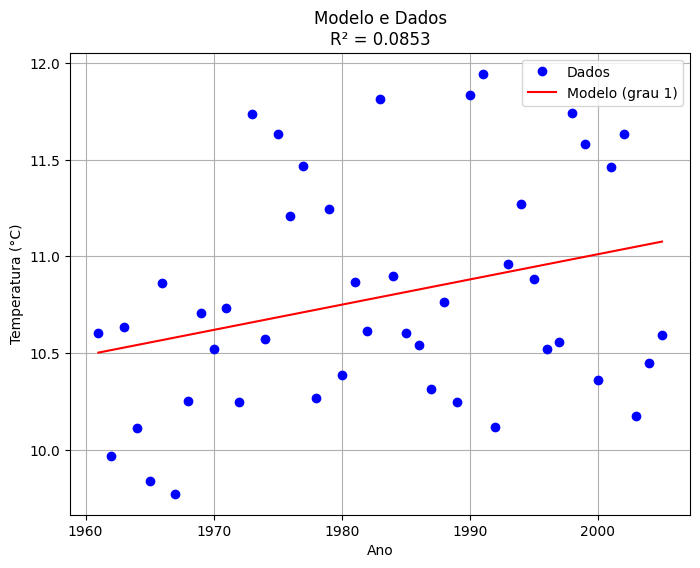

Qualidade do ajuste (R²): 0.0853


In [187]:
# Problem 4: FILL IN MISSING CODE TO GENERATE y VALUES
x1 = INTERVAL_1
y = []

# Gerar os valores de y como a temperatura média anual em Boston
for year in x1:
    yearly_temps = raw_data.get_yearly_temp('BOSTON', year)
    y.append(np.mean(yearly_temps))

# Criar modelos e avaliar os resultados
models = generate_models(x1, y, [1])
evaluate_models_on_training(x1, y, models)

**Exemplo do Problema 4**

* `x`: Intervalo 2, anos 2006 a 2016.
* `y`: Temperaturas em Boston nos respectivos anos.
* `models`: modelo ajustado ao polinômio de grau 1.

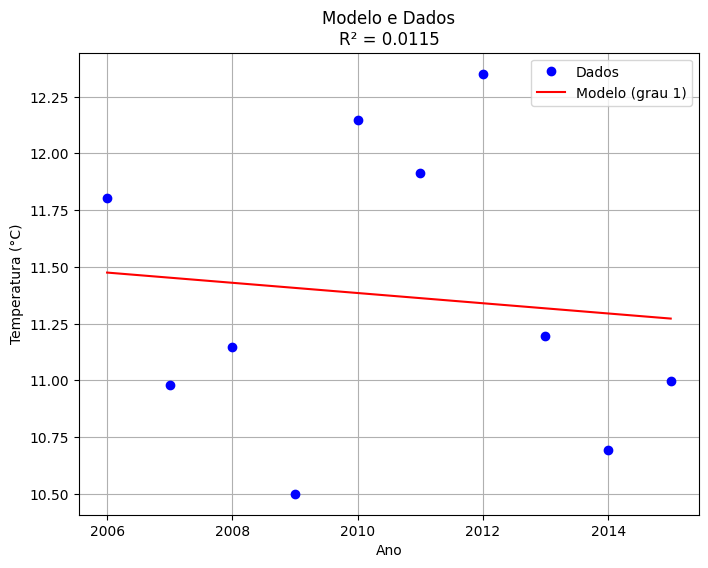

Qualidade do ajuste (R²): 0.0115


In [189]:
x2 = INTERVAL_2
y = []

for year in x2:
    yearly_temps = raw_data.get_yearly_temp('BOSTON', year)
    y.append(np.mean(yearly_temps))

# Criar modelos e avaliar os resultados
models = generate_models(x2, y, [1])
evaluate_models_on_training(x2, y, models)

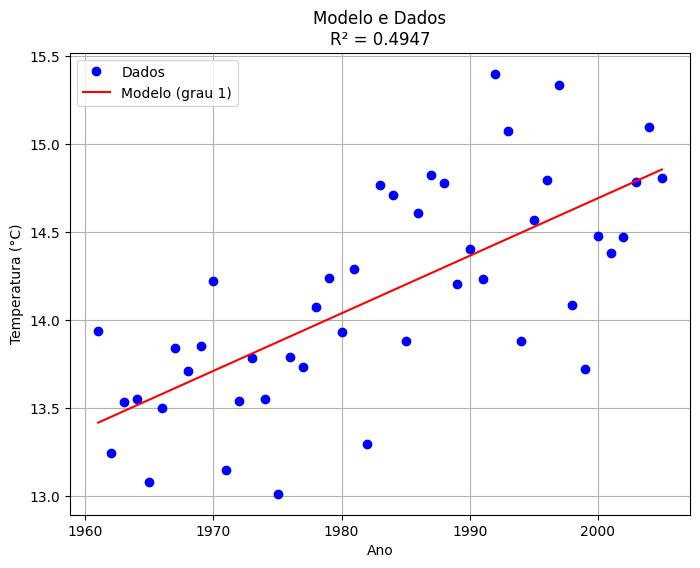

Qualidade do ajuste (R²): 0.4947


In [190]:
# Problem 4: FILL IN MISSING CODE TO GENERATE y VALUES
x1 = INTERVAL_1
x2 = INTERVAL_2
y = []

# Gerar os valores de y como a temperatura média anual em Boston
for year in x1:
    yearly_temps = raw_data.get_yearly_temp('SAN FRANCISCO', year)
    y.append(np.mean(yearly_temps))

# Criar modelos e avaliar os resultados
models = generate_models(x1, y, [1])
evaluate_models_on_training(x1, y, models)
